In [9]:
# import the necessaary packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
%matplotlib inline

import sys
file_path = "https://raw.githubusercontent.com/FarzinSohraby/PathInHydro/refs/heads/main/"

In [2]:
def alter_color(color, darken=1.2, desaturate=1.2):
    import matplotlib.colors as mc
    import colorsys
    # Convert to RGB
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    # Modify lightness and saturation
    h, l, s = c
    l = max(0, min(1, 1 - darken * (1 - l)))  # Clamp lightness
    s = max(0, min(1, 1 - desaturate * (1 - s)))  # Clamp saturation
    # Convert back to RGB
    c1 = colorsys.hls_to_rgb(h, l, s)
    return c1

# Define color palette
categories = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10']
color_palette = ['#1F77B4', '#bcbd22', '#D62728', '#9467BD', '#7F7F7F', '#E377C2', '#17BECF', '#FF7F0E', '#8C564B', '#000001']
# adjust the colors slightly to compensate for the reduced opacity
palette_brighten = [alter_color(c, darken=1.05, desaturate=0.9) for c in color_palette]
palette_dict = dict(zip(categories, palette_brighten))

In [3]:
# datasheets to process with their respective titles
datasheets_and_titles = {
    "Df_H2ase_CO_H2": 'Df-H$_2$ase-CO/Df-H$_2$ase-H$_2$ data set',
    "Mdg_H2ase_CO": 'Mdg-H$_2$ase-CO data set',
    "Mdg_H2ase_H2": 'Mdg-H$_2$ase-H$_2$ data set',
    "Mdg_H2ase_O2": 'Mdg-H$_2$ase-O$_2$ data set',
    "Df_H2ase_O2": 'Df-H$_2$ase-O$_2$ data set'
}

# Function to extract information from the 'Trajectory' column
def info_from_name(row):
    nm = row.Trajectory
    if '-CO' in nm:
        info = nm.split('-CO')
    elif '-H2' in nm:
        info = nm.split('-H2')
    else:
        info = [nm]
    return info[0]

# Function to rename features for better readability
def rename_features(orinm, updt_fmt='{1}:{0}'):
    resid_id = orinm.split("--")[-1]
    if "{1}" in updt_fmt:
        updtnm = updt_fmt.format(resid_id, orinm[5])
    else:
        updtnm = updt_fmt.format(resid_id)
    return updtnm

# Function to load data based on the specified datasheet
def load_data(datasheet):
    data = pd.read_csv(f'{file_path}{datasheet}.csv')
    if datasheet == "Df_H2ase_CO_H2":
        data['protein'] = data.apply(info_from_name, axis=1)
        data.set_index('Trajectory', inplace=True)
        data.drop(["Frame"], axis=1, inplace=True)
        non_feature = ['Pathway-new', 'Binary','protein']
    elif datasheet == "Mdg_H2ase_CO":
        data.set_index('Trajectory', inplace=True)
        data.drop(["Frame"], axis=1, inplace=True)
        non_feature = ['Pathway-new', 'Binary']
    elif datasheet == "Mdg_H2ase_H2":
        data.set_index('Trajectory', inplace=True)
        data.drop(["Frame"], axis=1, inplace=True)
        non_feature = ['Pathway-new', 'Binary']
    elif datasheet == "Mdg_H2ase_O2":
        data.set_index('Trajectory', inplace=True)
        data.drop(["Frame"], axis=1, inplace=True)
        non_feature = ['Pathway-new', 'Binary']
    elif datasheet == "Df_H2ase_O2":
        data.set_index('Trajectory', inplace=True)
        data.drop(["Frame"], axis=1, inplace=True)
        non_feature = ['Pathway-new', 'Binary']
    else:
        raise ValueError("Unknown datasheet")

    # Remove columns with only one unique value
    data = data.loc[:, data.apply(pd.Series.nunique) != 1]

    return data, non_feature


def perform_tsne_and_plot(datasheet, normalize_features=True,
                          perplexity=5, early_exaggeration=12.0):
    data, non_feature = load_data(datasheet)

    # Extract and prepare the features
    feat = data.drop(non_feature, axis=1)
    if normalize_features:
        tsne_mat = StandardScaler().fit_transform(feat)
    else:
        tsne_mat = feat

    # Perform t-SNE analysis
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca',
                      perplexity=perplexity, early_exaggeration=early_exaggeration,
                      random_state=1).fit_transform(tsne_mat)

    # Create a DataFrame for t-SNE results
    tsne_df = pd.DataFrame(data=X_embedded, columns=['d1', 'd2'])
    tsne_df['path'] = list(data['Pathway-new'])

    # Define order for hue categories (include all possible categories)
    hue_order = categories  # Use all categories from the predefined list

    # Determine plot settings based on datasheet
    if datasheet == "Df_H2ase_CO_H2":
        style_protein = list(data['protein'])
        figsize = (10, 7)
    else:
        style_protein = None
        figsize = (4, 4)

    # Plot t-SNE results
    fig = plt.figure(figsize=figsize)
    ax = sns.scatterplot(
        data=tsne_df,
        x="d1", y="d2",
        hue="path",
        hue_order=hue_order,  # Ensure all categories are included in the legend
        palette=palette_dict,
        style=style_protein,
        legend="full",
        alpha=0.7,
        linewidth=0
    )

    # Add empty legend entries for missing categories
    handles, labels = ax.get_legend_handles_labels()
    existing_labels = set(labels)
    for category in categories:
        if category not in existing_labels:
            handles.append(plt.Line2D([], [], marker='o', linestyle='', color=palette_dict[category]))
            labels.append(category)

    # Update the legend
    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1), title="Categories")

    plt.title(datasheets_and_titles[datasheet], fontsize=16)
    plt.show()

    return(fig)

def save_figure(fig, datasheet, fig_name=None, dir=file_path):
    if not fig_name:
        fig_name = f"{datasheet}_tsne.jpg"
    if '.' not in fig_name:
        fig_fmt = 'jpg'
        fig_name = fig_name + '.jpg'
    else:
        fig_fmt = fig_name.split('.')[-1]
    fig.savefig(f"{file_path}/{fig_name}", dpi=300, format=fig_fmt, bbox_inches='tight')

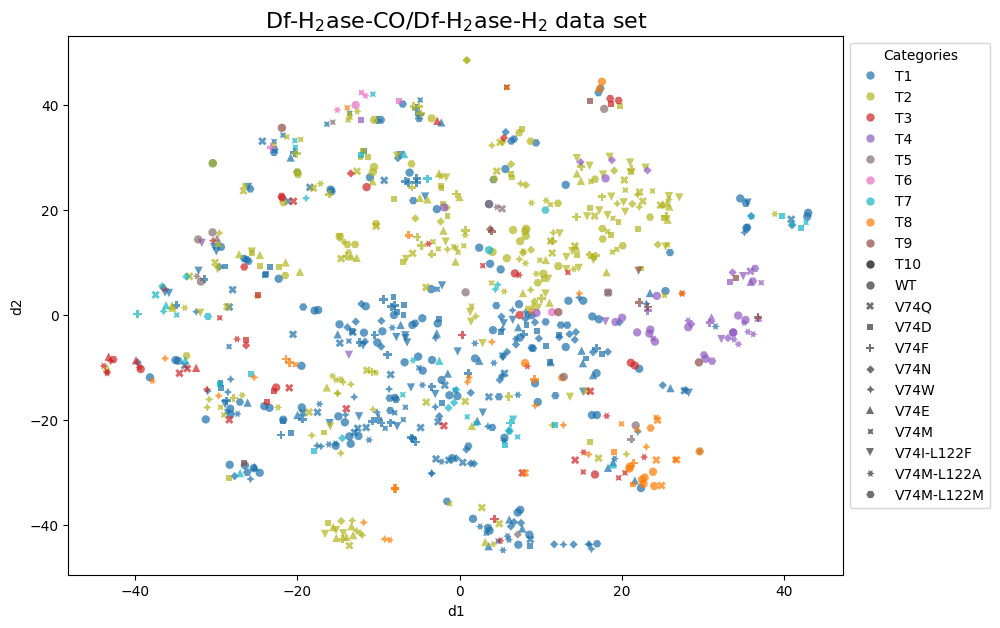

In [4]:
fig_Df_CO = perform_tsne_and_plot("Df_H2ase_CO_H2", perplexity=17, early_exaggeration=29)

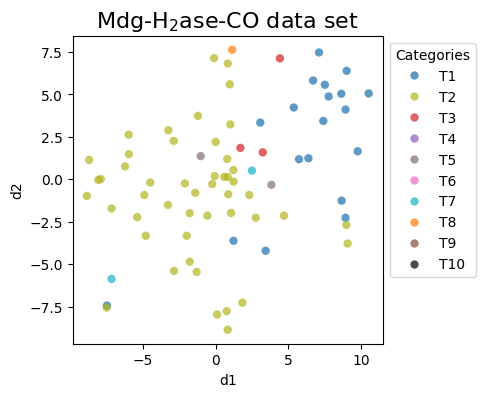

In [5]:
fig_Mdg_CO = perform_tsne_and_plot("Mdg_H2ase_CO", perplexity=8, early_exaggeration=17)

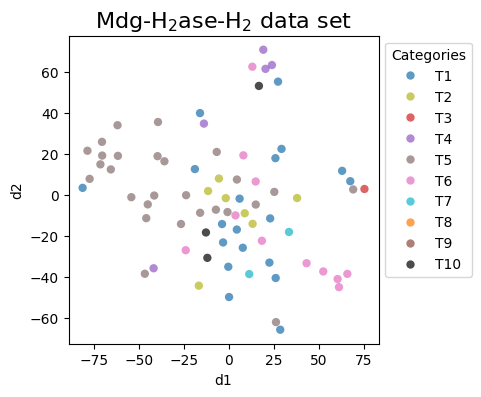

In [6]:
fig_Mdg_H2 = perform_tsne_and_plot("Mdg_H2ase_H2", perplexity=3, early_exaggeration=7)

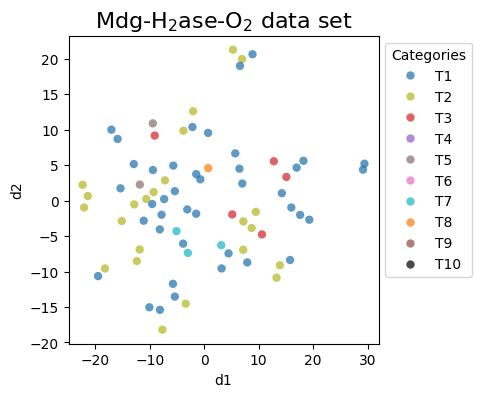

In [7]:
fig_Mdg_O2 = perform_tsne_and_plot("Mdg_H2ase_O2", perplexity=5, early_exaggeration=9)

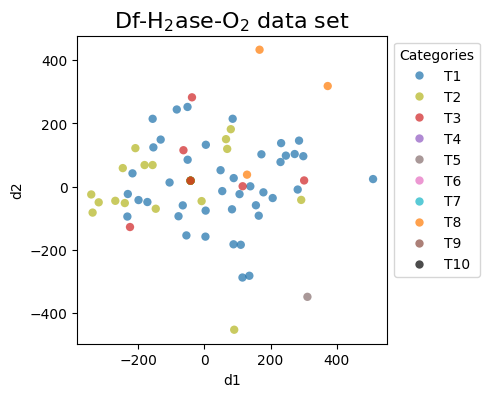

In [8]:
fig_Df_O2 = perform_tsne_and_plot("Df_H2ase_O2", perplexity=6, early_exaggeration=12)

In [11]:
fig_Df_CO.savefig(f"{file_path}/Df_CO_H2.jpg", dpi=300, format='jpg', bbox_inches='tight')
fig_Mdg_CO.savefig(f"{file_path}/Mdg_CO.jpg", dpi=300, format='jpg', bbox_inches='tight')
fig_Mdg_O2.savefig(f"{file_path}/Mdg_O2.jpg", dpi=300, format='jpg', bbox_inches='tight')
fig_Mdg_H2.savefig(f"{file_path}/Mdg_H2.jpg", dpi=300, format='jpg', bbox_inches='tight')
fig_Df_O2.savefig(f"{file_path}/Df_O2.jpg", dpi=300, format='jpg', bbox_inches='tight')